# Filtering of ERT and IP data

Adapted from:
Flores Orozco A., Gallistl J., Bücker M. & Williams K. (2018). Decay curve analysis for
data error quantification in time-domain induced polarization imaging. GEOPHYSICS, 83 (2),
1MA-Z8. https://doi.org/10.1190/geo2016-0714.1

Use only for IP filtering or when reciprocals are not present.

In [80]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize_scalar
from matplotlib import pyplot as plt
from pygimli.frameworks import fit as fitFunc

import ExtractLines as el

import re
# From StackOverflow: https://stackoverflow.com/questions/4703390/how-to-extract-a-floating-number-from-a-string
numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
floatsExtractor = re.compile(numeric_const_pattern, re.VERBOSE)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# Counters initializer:
nbFails = 0
value = 0
# Global values:
graphs = True

## Defining common functions:
def computeChargeability(IP, windows):
    a = 0
    for i, ti in enumerate(windows):
        a += IP[i]*ti
    return a/np.sum(windows)

def chargeaOpti(t, alpha, beta, eps):
    return alpha * np.power(t, -beta) + eps

def fitChargea(IP, times, res):
    global nbFails, value, graphs
    try:
        # popt, _ = fitFunc(chargeaOpti, IP, t=times)
        popt, pcov = curve_fit(chargeaOpti, times, IP, np.asarray([10, 0.1, 0]), maxfev=10000, method='trf')
        alpha   = popt[0]
        beta    = popt[1]
        eps     = popt[2]
        if graphs and (value % 100 == 0):
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(times, IP, 'or')
            ax.plot(times, chargeaOpti(times, alpha, beta, eps))
            ax.set_title(f'R = {res}')
            plt.show(block=False)
        value += 1
    except:
        nbFails +=1
        alpha   = np.NaN
        beta    = np.NaN
        eps     = np.NaN
        if graphs:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(times, IP, 'or')
            ax.set_title(f'R = {res}')
            plt.show(block=False)
    return alpha, beta, eps

def computeRMSD(IP, times, alpha, beta, eps):
    return np.sqrt(1/len(IP) * np.sum(np.power(chargeaOpti(times, alpha, beta, eps) - IP, 2)))

def referenceMedian(row, df, times):
    # Find the index of similar A and B:
    currDf = df[(df['A(x)'] == row['A(x)']) & (df['A(y)'] == row['A(y)']) & (df['A(z)'] == row['A(z)']) &
                (df['B(x)'] == row['B(x)']) & (df['B(y)'] == row['B(y)']) & (df['B(z)'] == row['B(z)'])] # Select the rows with the same a and b as the idxRow one.
    # Compute the reference:
    ref = np.median(np.asarray([chargeaOpti(times, rowLoop['alpha'], rowLoop['beta'], rowLoop['eps']) for _, rowLoop in currDf.iterrows()]), axis=0)
    return ref

def rmsdRef(ref, fit):
    return np.sqrt(1/len(ref) * np.sum(np.power(ref - fit, 2)))

def computeShift(ref, fit):
    ku = np.nan
    kd = np.nan
    def misfitShift(k):
        return rmsdRef(ref, fit+k)
    kOpt = minimize_scalar(misfitShift)
    if kOpt.success:
        kOpt = kOpt.x
        if kOpt < 0:
            kd = -kOpt
        else:
            ku = kOpt
    else:
        print('Failed to minimize the functional')
    return ku, kd

### Define the main variables:

In [81]:
## Main parametres:
fileName = './AgatheData/Project2_G7_ABMN_2.txt'
errorModelling = True

### Loading the dataset

In [82]:
## Reading the file using pandas
deltaT = None
f = open(fileName, 'r')
for line in f.readlines():
    if deltaT is not None:
        break
    if 'IP_WindowSecList' in line:
        deltaT = [float(i) for i in floatsExtractor.findall(line)]
lineHeaders, lineEnd = el.getLines(filename=fileName)
dataSet = pd.read_csv(fileName, skiprows=lineHeaders, nrows=lineEnd-lineHeaders-2, sep='\t', index_col=False) # Need to check for 2 rows too much. Is it the case for every files???
nbDataInit = dataSet.shape[0]
delayT = deltaT[0]
deltaT = deltaT[1:]
timesIP = (np.cumsum(deltaT) + delayT) * 1000   # Time for the windows (msec)
print(f'Delay Time (sec): {delayT}')
print(f'Window times ({len(deltaT)}): {deltaT}')
print(f'Number of data points: {dataSet.shape[0]} ({dataSet.shape[0]/nbDataInit*100} %)')

ipData = [col for col in dataSet if col.startswith('IP #')]
print(dataSet[ipData].describe())

Delay Time (sec): 0.01
Window times (20): [0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04, 0.05, 0.05, 0.07, 0.07, 0.09, 0.09, 0.13, 0.13, 0.2, 0.2, 0.29, 0.29]
Number of data points: 1332 (100.0 %)
       IP #1(mV/V)  IP #2(mV/V)  IP #3(mV/V)  IP #4(mV/V)  IP #5(mV/V)  \
count  1332.000000  1332.000000  1332.000000  1332.000000  1332.000000   
mean     55.268336    43.056038    36.845283    31.323557    27.272282   
std      89.202398   125.013937   119.788547   116.599681   109.867716   
min   -2553.391346 -4262.216001 -4147.832811 -4076.337893 -3858.322941   
25%      32.631806    23.006882    19.259125    16.311049    14.305649   
50%      62.119066    51.185074    44.287714    38.485799    33.826970   
75%      78.455920    64.833787    56.234174    48.546080    42.720796   
max     776.060576   704.743367   631.422593   568.153571   513.637580   

       IP #6(mV/V)  IP #7(mV/V)  IP #8(mV/V)  IP #9(mV/V)  IP #10(mV/V)  \
count  1332.000000  1332.000000  1332.000000  1332.000000  

### Fitting of a power law

07/04/22 - 10:26:34 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:34 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]


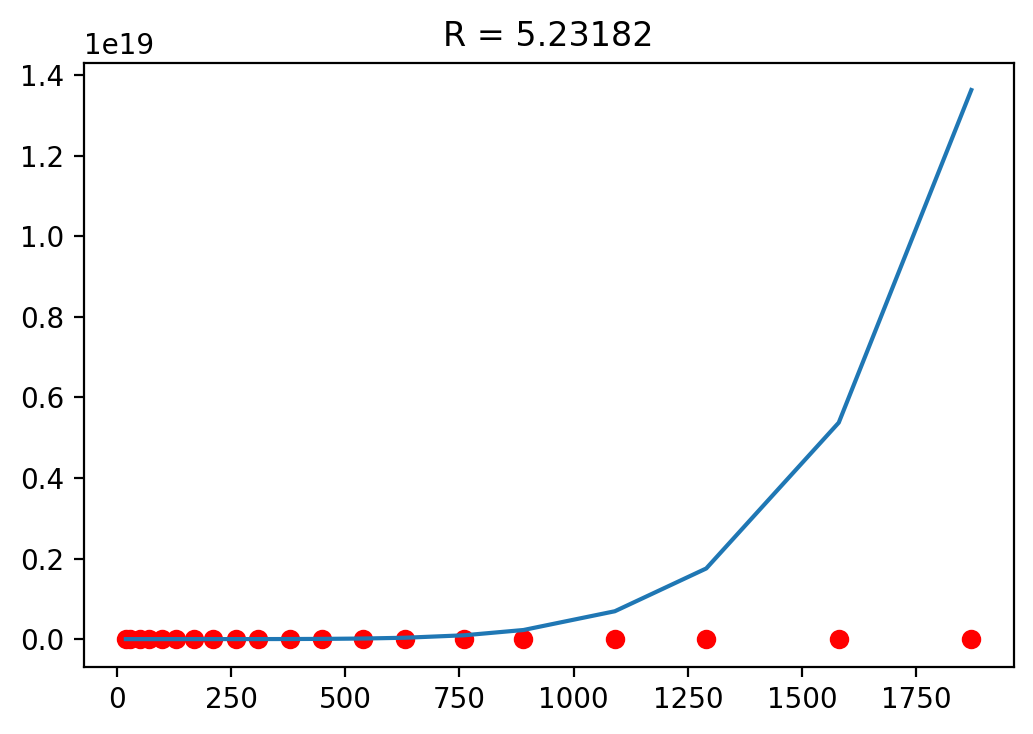

07/04/22 - 10:26:34 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:34 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:34 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:34 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:34 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:34 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:35 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]


C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:35 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:35 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:35 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:36 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:36 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]


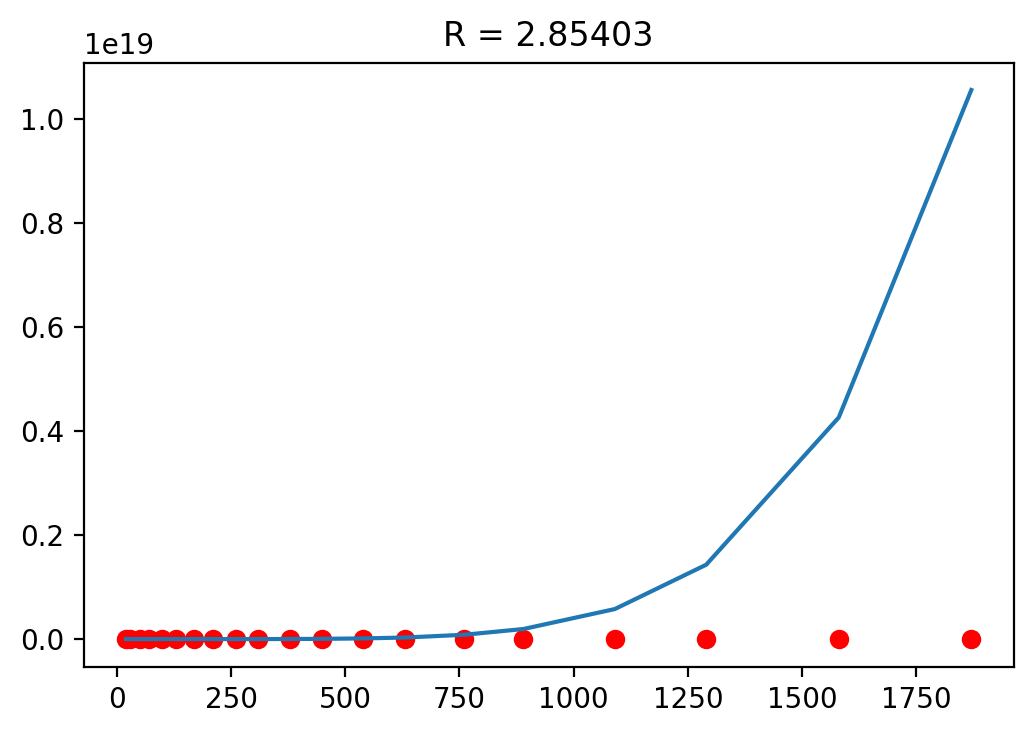

07/04/22 - 10:26:37 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:37 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:37 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:37 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:38 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:38 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:38 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:38 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:38 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:38 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:38 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:40 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model


C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:40 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:26:40 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:40 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:40 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:40 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:40 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:40 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:40 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:40 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:40 - pyGIMLi 

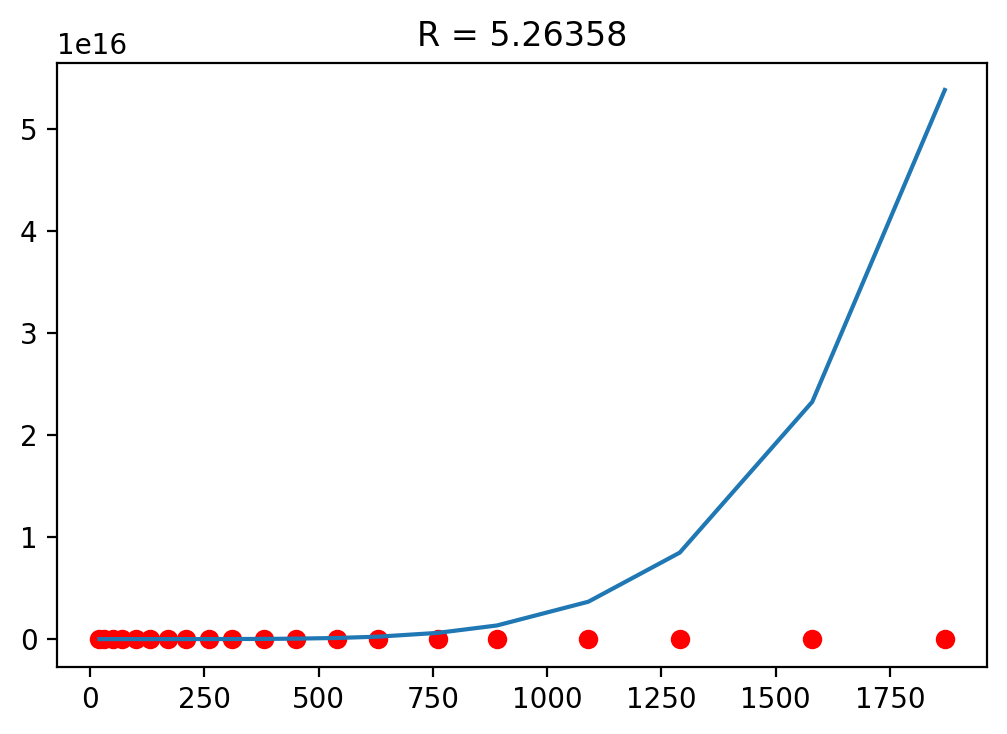

07/04/22 - 10:26:41 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:41 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:41 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:41 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:41 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:41 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:41 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:41 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:41 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:41 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:41 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:43 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model


C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:43 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:43 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:43 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:43 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:43 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:43 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:43 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:43 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:43 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:43 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:43 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

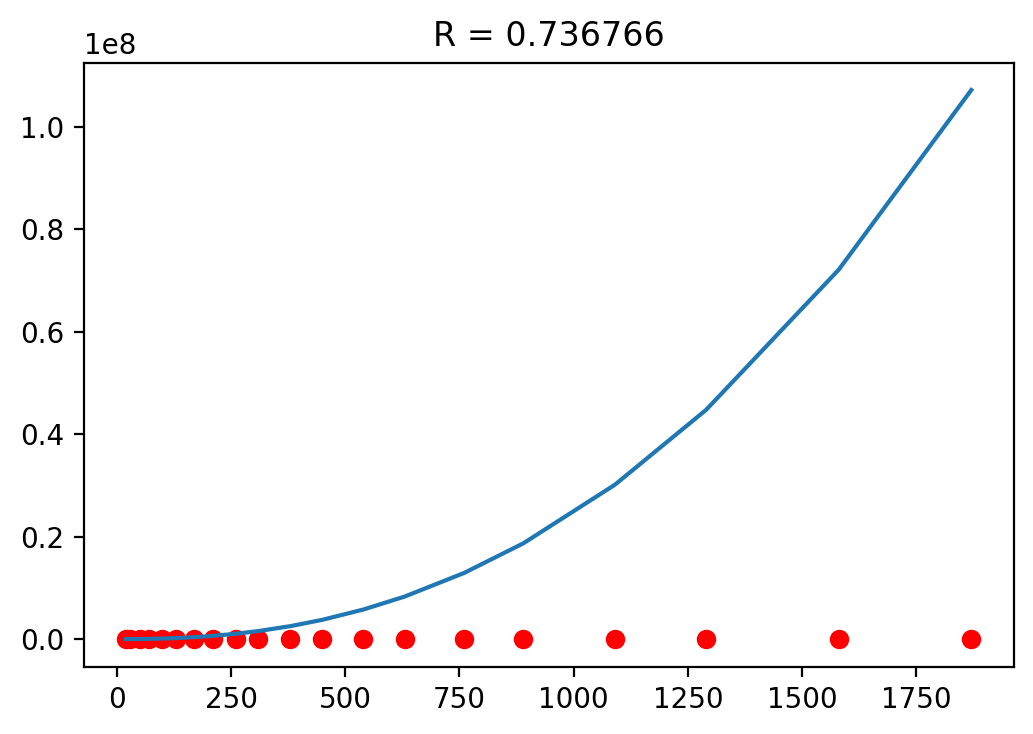

07/04/22 - 10:26:44 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:44 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:44 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:44 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:44 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:44 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:44 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:44 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:44 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:44 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:44 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:46 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:46 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:46 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:46 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:46 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:46 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:46 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:46 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:46 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:46 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:46 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

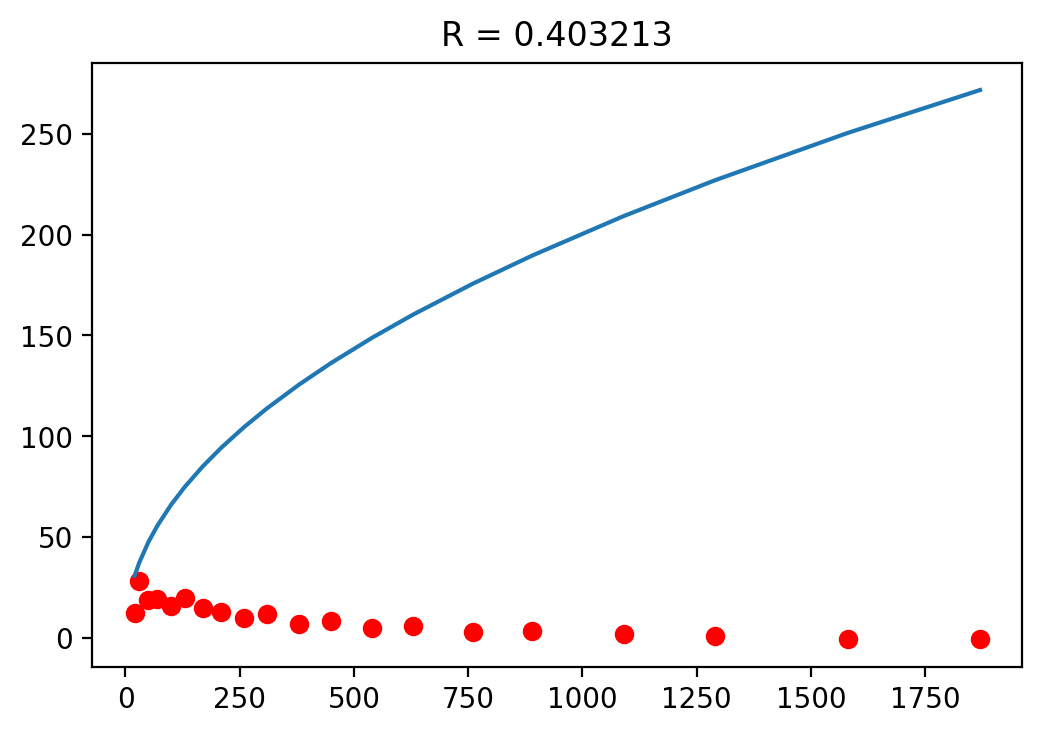

07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:47 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:47 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:47 - pyGIMLi 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:48 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:26:48 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:48 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:48 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:48 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:48 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:48 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:48 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:48 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:48 - pyGIMLi 

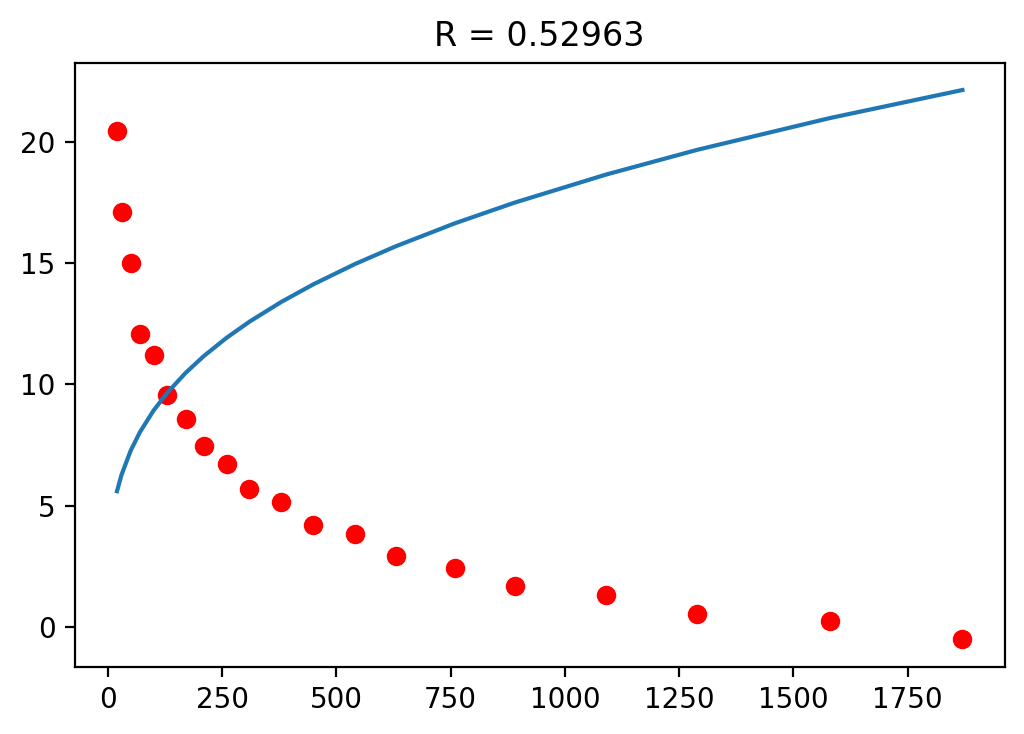

07/04/22 - 10:26:50 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:50 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:50 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:50 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:50 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:50 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:50 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:50 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:50 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:50 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:50 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

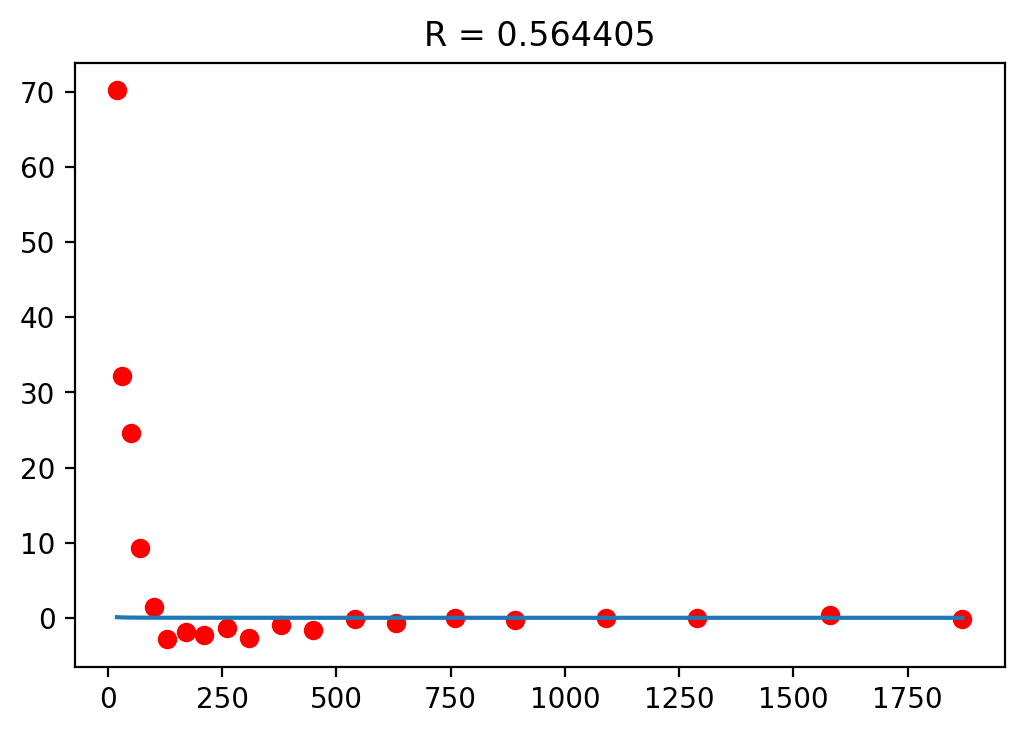

07/04/22 - 10:26:53 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:53 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:53 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:53 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:53 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:53 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:53 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:53 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:53 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:53 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:53 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:55 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:26:55 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:55 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:55 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:55 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:55 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:55 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:55 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:55 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:55 - pyGIMLi 

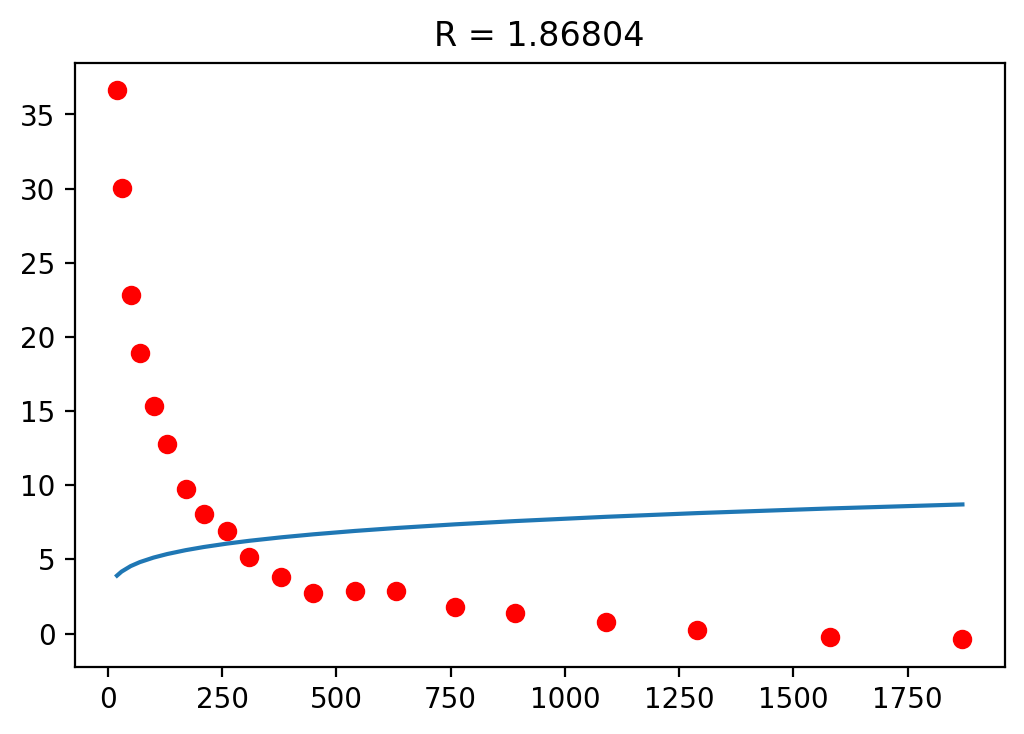

07/04/22 - 10:26:56 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:56 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:56 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:56 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:56 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:56 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:56 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:56 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:56 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:56 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:56 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

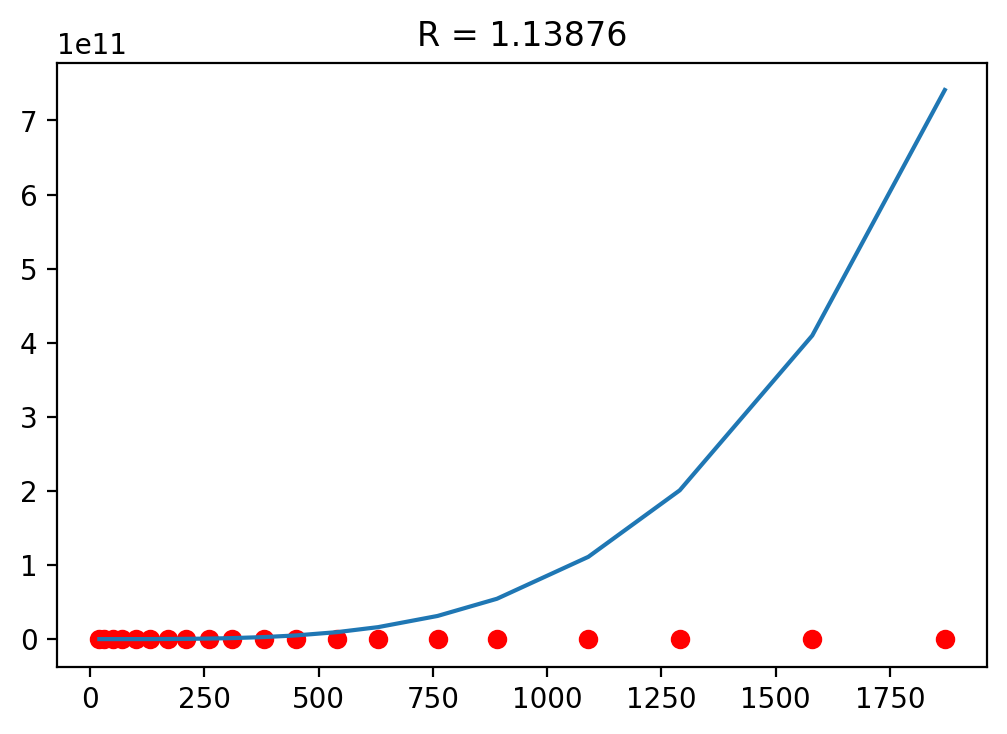

07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:26:59 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:26:59 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:26:59 - pyGIMLi 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:00 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:27:00 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:00 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:00 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:00 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:00 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:00 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:00 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:00 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:00 - pyGIMLi 

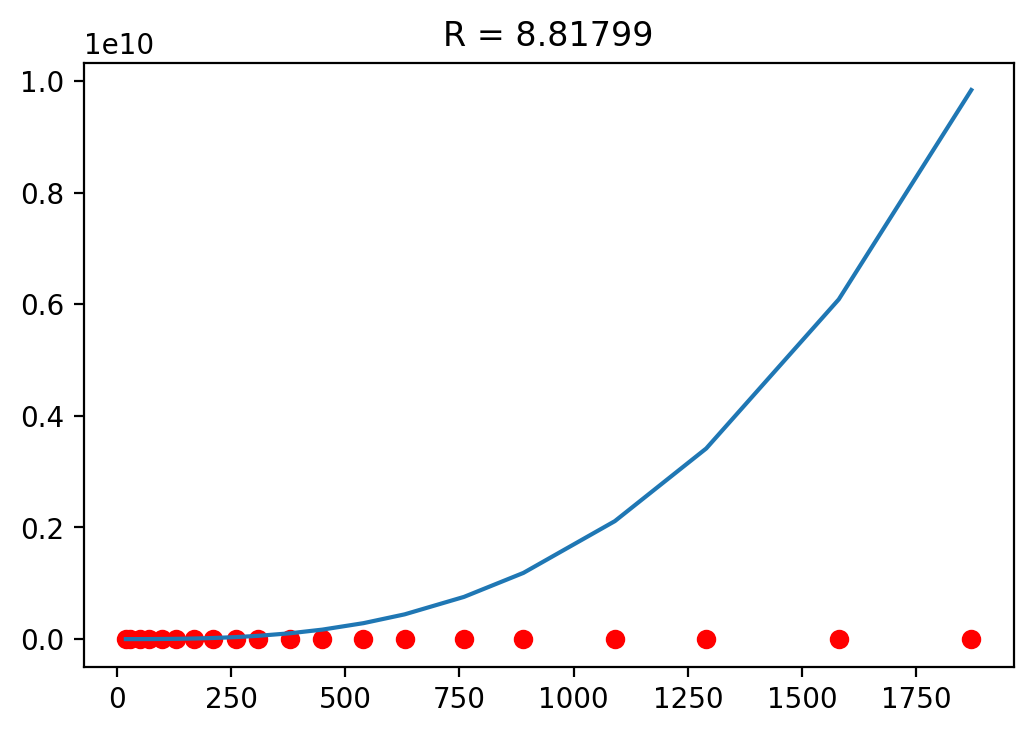

07/04/22 - 10:27:02 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:02 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:02 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:02 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:02 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:02 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:02 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:02 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:02 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:02 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:02 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

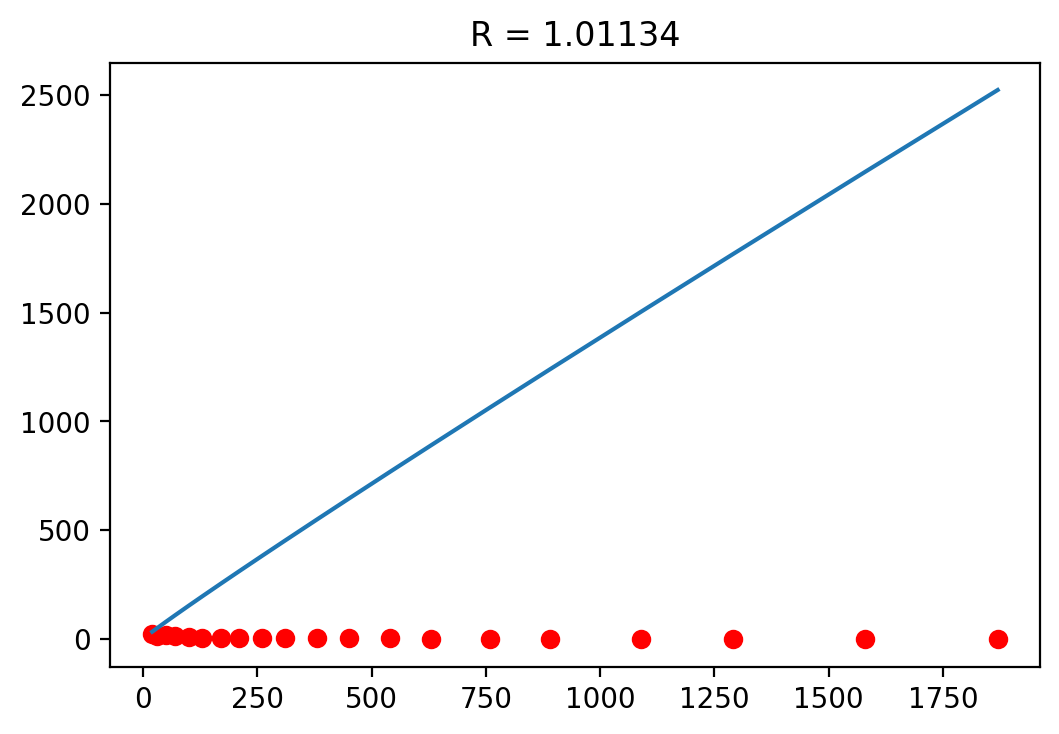

07/04/22 - 10:27:04 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:04 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:04 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:04 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:04 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:04 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:04 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:04 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:04 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:04 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:04 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:05 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:27:05 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%


C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:05 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:05 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:05 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:05 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:05 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:05 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:05 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:05 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:05 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:05 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:05 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]


C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:06 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:06 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:06 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:06 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:06 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:06 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:06 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:06 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:06 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:06 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:06 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:07 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:07 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:07 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:07 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:07 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:07 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:07 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:07 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:07 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:07 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:07 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

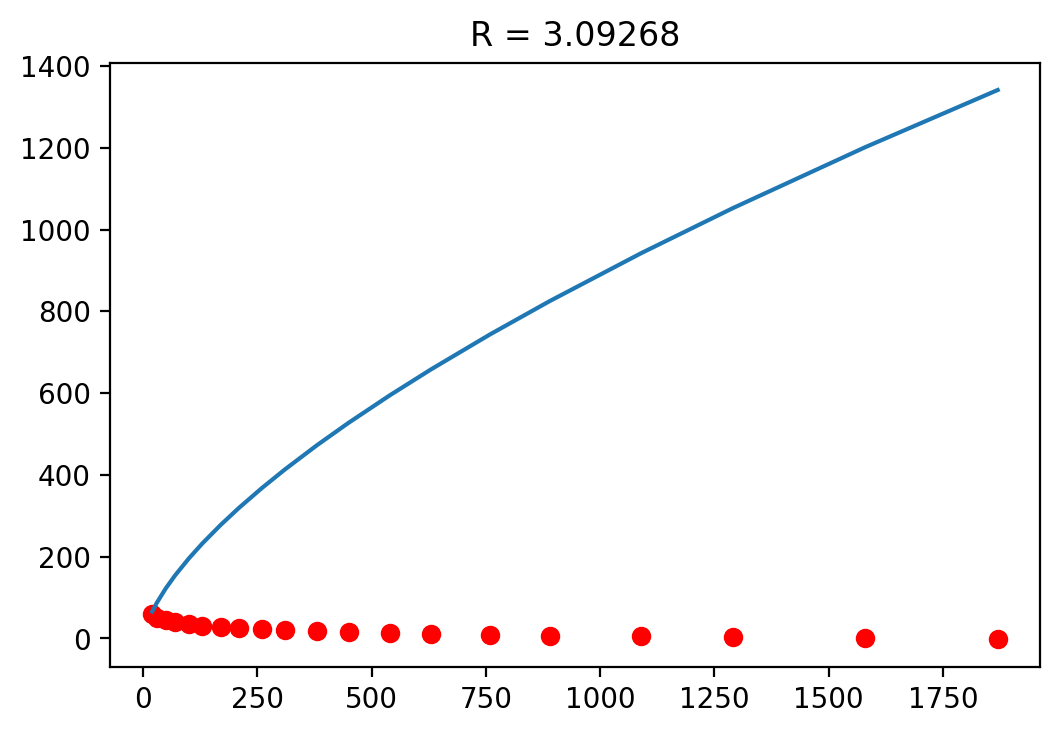

07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf
C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:08 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:08 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:08 - pyGIMLi 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:09 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:09 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:09 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:09 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:09 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:09 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:09 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:09 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:09 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:09 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:09 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

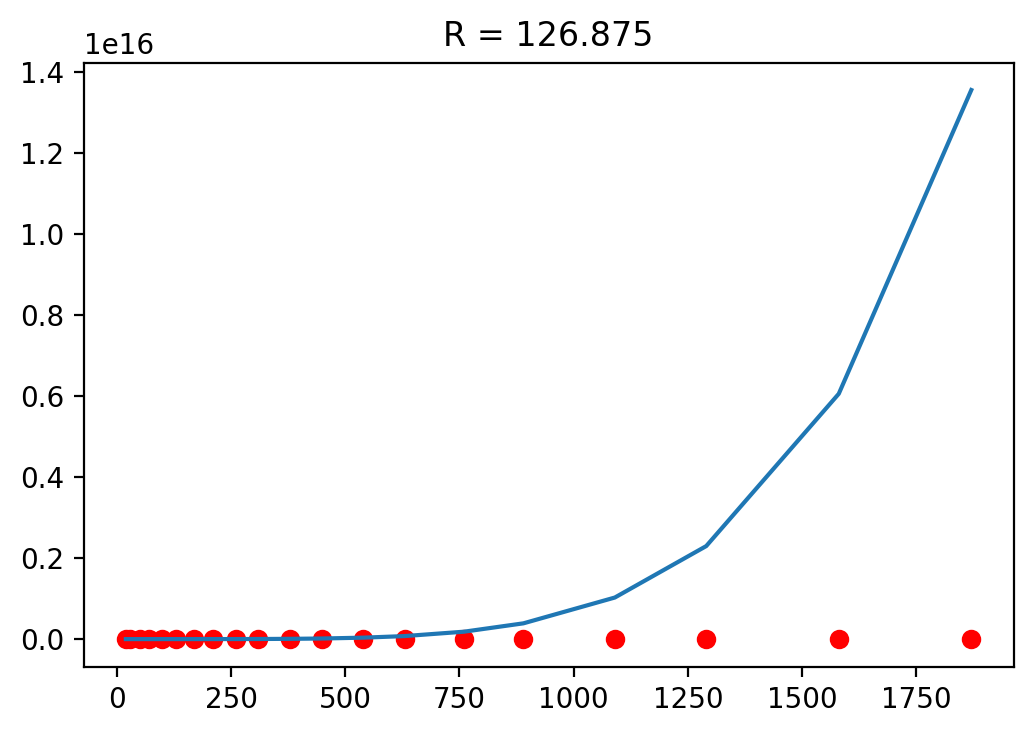

07/04/22 - 10:27:11 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:11 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:11 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:11 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:11 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:11 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:11 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:11 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:11 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:11 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:11 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:12 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model


C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:13 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:13 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:13 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:13 - pyGIMLi 

C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:13 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model
07/04/22 - 10:27:14 - pyGIMLi - ERROR - <class 'pygimli.frameworks.inversion.MarquardtInversion'>.run(C:\Software\Anaconda3\envs\pybert\lib\site-packages\pygimli\frameworks\inversion.py:455)
One step failed. Aborting and going back to last model


C:/msys64/home/halbm/gimli/gimli/core/src/inversion.cpp:95		double GIMLI::RInversion::getPhiD(const Vec&) const  getPhiD == inf


07/04/22 - 10:27:14 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:14 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:14 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:14 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:14 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:14 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:14 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:14 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:14 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:14 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:14 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

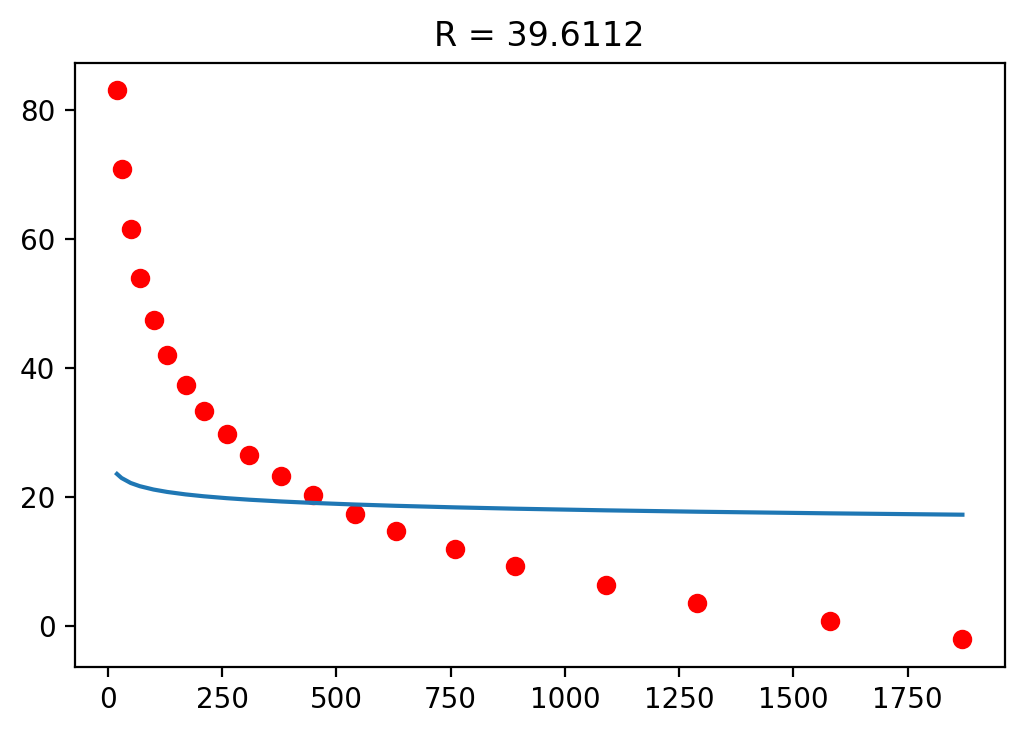

07/04/22 - 10:27:15 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:15 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:15 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:15 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:15 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:15 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:15 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:15 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:15 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 - 10:27:15 - pyGIMLi - INFO - Created startmodel from region infos: 3 [1.0, 1.0, 1.0]
07/04/22 - 10:27:15 - pyGIMLi - WARNING - No data array given, set Fallback set to 1%
07/04/22 

       Chargeability (mV/V)        alpha         beta
count           1332.000000  1332.000000  1332.000000
mean               6.552911     7.480385    -1.272390
std               35.638339     9.713643     2.722418
min            -1264.825313    -6.533476    -6.011520
25%                3.319445     2.519516    -2.817662
50%                8.354981     4.593494    -1.040511
75%               10.656879     9.744471    -0.233834
max              147.321642   107.806622    21.234669
Number of failed fit: 0


In [83]:
## Fitting of a power law mf(t) = alpha*t^(-beta) + eta:
dataSet['Chargeability (mV/V)'] = dataSet.apply(lambda row: computeChargeability(row[ipData], deltaT), axis=1)
dataSet[['alpha', 'beta', 'eps']] = dataSet.apply(lambda row: fitChargea(row[ipData], timesIP, row['R(Ohm)']), axis=1, result_type='expand')
dataSet = dataSet.dropna(subset=['alpha', 'beta', 'eps'])
print(dataSet[['Chargeability (mV/V)', 'alpha', 'beta']].describe())
print(f'Number of failed fit: {nbFails}')
if graphs: 
    plt.show()

### Fisrt filter (decaying curve?)

In [84]:
## Fisrt filter (non decaying curves) - alpha and beta of diferent signs:
prod = np.multiply(dataSet['alpha'], dataSet['beta'])
dataSet = dataSet[prod>0]
print(f'Number of data points after the first filter: {dataSet.shape[0]} ({dataSet.shape[0]/nbDataInit*100} %)')
## Root mean square deviation computation:
dataSet['rmsd'] = dataSet.apply(lambda row: computeRMSD(row[ipData], timesIP, row['alpha'], row['beta'], row['eps']), axis=1)
print(dataSet['rmsd'].describe())

Number of data points after the first filter: 247 (18.543543543543546 %)
count      247.000000
mean       419.551169
std       3780.669903
min          3.098252
25%         12.582782
50%         21.623680
75%         27.120493
max      56008.683603
Name: rmsd, dtype: float64


### Construction of reference curves

In [85]:
## Construction of reference curves for each AB couples:
dataSet['Reference'] = dataSet.apply(lambda row: referenceMedian(row, dataSet, timesIP), axis=1) # Median curve
dataSet['Fitted'] = dataSet.apply(lambda row: chargeaOpti(timesIP, row['alpha'], row['beta'], row['eps']), axis=1) # Fitted curve
dataSet['Measured'] = dataSet.apply(lambda row: np.asarray(row[ipData]).flatten(), axis=1) # Measured curve

dataSet[['ku', 'kd']] = dataSet.apply(lambda row: computeShift(row['Reference'], row['Fitted']), axis=1, result_type='expand')

### Second filter (far from reference)

In [86]:
## Second filter (far from reference curves):
stdKu = dataSet['ku'].std()
stdKd = dataSet['kd'].std()
# Calculating the noise level:
kuMult, kdMult = 3, 3 # General case
if 3*stdKu >  2*dataSet['Chargeability (mV/V)'].median():
    print('The dataset is noisy!')
    # Noisy dataset
    kuMult, kdMult = 1.5, 1
elif 3*stdKu < dataSet['Chargeability (mV/V)'].median():
    # Clean dataset
    print('The dataset is clean!')
    kuMult, kdMult = 4, 4

dataSet = dataSet[(dataSet['ku'] < kuMult*stdKu) | (dataSet['kd'] < kdMult*stdKd)]
print(f'Number of data points after the second filter: {dataSet.shape[0]} ({dataSet.shape[0]/nbDataInit*100} %)')
print(dataSet['Chargeability (mV/V)'].describe())
dataSet = dataSet.reset_index(drop=True)
dataSet['DCAmisfit'] = dataSet.apply(lambda row: row['Fitted']-row['Measured'], axis=1)

The dataset is noisy!
Number of data points after the second filter: 241 (18.093093093093092 %)
count     241.000000
mean        0.404605
std        82.881045
min     -1264.825313
25%         2.983614
50%         7.294588
75%         8.910857
max       147.321642
Name: Chargeability (mV/V), dtype: float64


# Building an error model

Error model for IP: s = 0.08153996171722087R^-4.062862966374982
Error model for IP(r): s = 104.47278182938933/R + 46.42477183514775


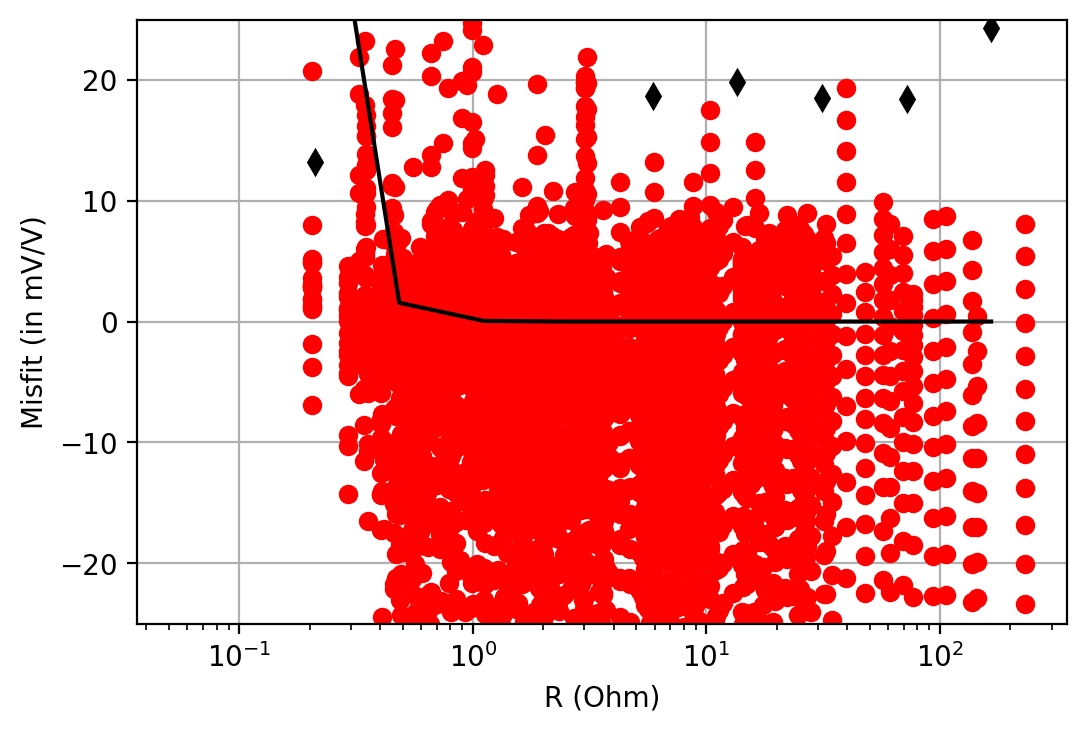

In [87]:
nbBins = 10

fig = plt.figure()
ax = fig.add_subplot(111)
for _, row in dataSet.iterrows():
    ax.plot(np.ones((len(timesIP),))*np.abs(row['R(Ohm)']), row['DCAmisfit'], 'or')
ax.set_xscale('log')
ax.set_xlabel('R (Ohm)')
ax.set_ylabel('Misfit (in mV/V)')
ax.set_ylim([-25, 25])
ax.grid()

bins = np.logspace(np.log10(dataSet['R(Ohm)'].min()), np.log10(dataSet['R(Ohm)'].max()), num=nbBins+1)
binsCenters = (bins[1:] + bins[:-1])/2
stdMisfit = np.zeros((nbBins,))
for i in range(nbBins):
    currData = dataSet[(dataSet['R(Ohm)']>=bins[i]) & (dataSet['R(Ohm)']<bins[i+1])]
    misfits = np.array(currData['DCAmisfit'].to_list()).flatten()
    stdMisfit[i] = np.std(misfits)
ax.plot(binsCenters, stdMisfit, 'dk')

def errorIP(R, a, b):
    return a * np.power(R, b)

popt, _ = curve_fit(errorIP, binsCenters, stdMisfit, bounds=([0, -np.inf], [np.inf, 0]))
a = popt[0]
b = popt[1]
print(f'Error model for IP: s = {a}R^{b}')
ax.plot(binsCenters, errorIP(binsCenters, a, b), 'k')

def errorIP_r(R, c, d):
    return np.divide(c, R) + d

popt, _ = curve_fit(errorIP_r, binsCenters, stdMisfit, bounds=(0, np.inf))
c = popt[0]
d = popt[1]
print(f'Error model for IP(r): s = {c}/R + {d}')
ax.plot(binsCenters, errorIP_r(binsCenters, c, d), 'g')

plt.show()